In [9]:

import pandas as pd, numpy as np, matplotlib.pyplot as plt, networkx as nx
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from mlxtend.frequent_patterns import apriori, association_rules

%matplotlib inline

DATA = Path('.')
file_sider = DATA / 'Siderurgia.xlsx'
file_pizza = DATA / 'pizzas_sc.xlsx'
print(file_sider.resolve())
print(file_pizza.resolve())


C:\Users\diasj\faculdade\RAD2810\atividade03\Siderurgia.xlsx
C:\Users\diasj\faculdade\RAD2810\atividade03\pizzas_sc.xlsx


## 1) Cluster — Siderurgia.xlsx

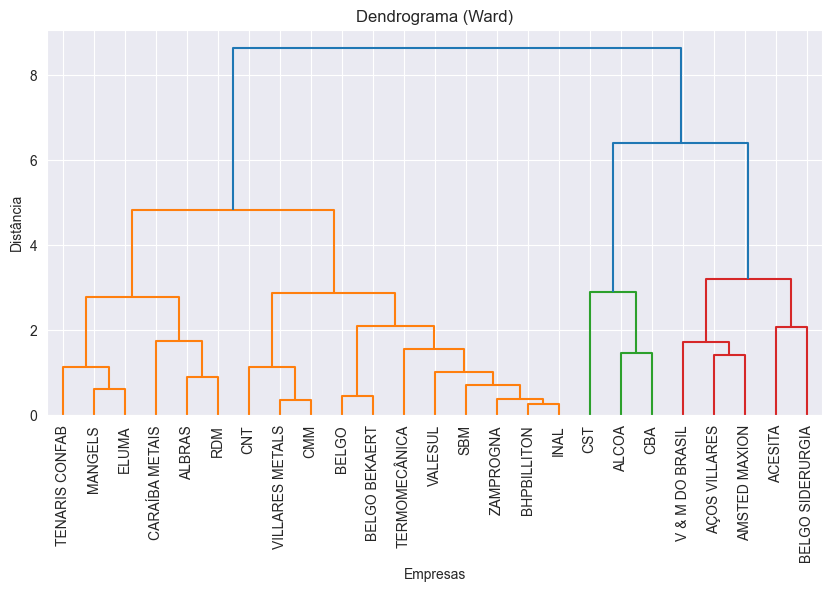

=== (1.1.b) Número de integrantes (Ward, 2 grupos) ===


,Grupo,N
0,1,17
1,2,8



(extra) Ward, 3 grupos


,Grupo,N
0,1,17
1,2,3
2,3,5


Silhouette (Ward k=2): 0.3968


In [10]:

xls = pd.ExcelFile(file_sider)
df_sid = pd.read_excel(file_sider, sheet_name=xls.sheet_names[0])

rename_map = {}
for c in df_sid.columns:
    lc = str(c).strip().lower()
    if 'fatur' in lc: rename_map[c] = 'Faturamento'
    elif 'rentab' in lc or 'rent ' in lc or 'rent.' in lc: rename_map[c] = 'Rentabilidade'
    elif 'endiv' in lc: rename_map[c] = 'Endividamento'
    elif 'empreg' in lc or 'nro' in lc or 'func' in lc: rename_map[c] = 'Nro.Empregados'
    elif lc in ['empresa','companhia','nome']: rename_map[c] = 'Empresa'

df_sid = df_sid.rename(columns=rename_map)
features = ['Faturamento','Rentabilidade','Endividamento','Nro.Empregados']
if 'Empresa' not in df_sid.columns:
    df_sid['Empresa'] = [f'Emp_{i+1}' for i in range(len(df_sid))]
df_sid = df_sid[['Empresa'] + features].dropna().copy()

X = df_sid[features].values.astype(float)
scaler = StandardScaler()
Z = scaler.fit_transform(X)

linkage_matrix = linkage(Z, method='ward')
plt.figure(figsize=(10,5))
dendrogram(linkage_matrix, labels=df_sid['Empresa'].tolist(), leaf_rotation=90)
plt.title("Dendrograma (Ward)")
plt.xlabel("Empresas"); plt.ylabel("Distância")
plt.show()

labels_2 = fcluster(linkage_matrix, t=2, criterion='maxclust')
labels_3 = fcluster(linkage_matrix, t=3, criterion='maxclust')
df_sid['Ward_k2'] = labels_2
df_sid['Ward_k3'] = labels_3
tab_k2 = df_sid['Ward_k2'].value_counts().sort_index()
tab_k3 = df_sid['Ward_k3'].value_counts().sort_index()

print("=== (1.1.b) Número de integrantes (Ward, 2 grupos) ===")
display(pd.DataFrame({'Grupo': tab_k2.index, 'N': tab_k2.values}))
print("\n(extra) Ward, 3 grupos")
display(pd.DataFrame({'Grupo': tab_k3.index, 'N': tab_k3.values}))

sil_ward2 = silhouette_score(Z, labels_2) if len(np.unique(labels_2))>1 else np.nan
print(f"Silhouette (Ward k=2): {sil_ward2:.4f}")


In [11]:

kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
km_labels = kmeans.fit_predict(Z)
df_sid['KMeans_k2'] = km_labels + 1

centroids_z = kmeans.cluster_centers_
centroids_df_z = pd.DataFrame(centroids_z, columns=[f'{c}_z' for c in ['Faturamento','Rentabilidade','Endividamento','Nro.Empregados']], index=[1,2])

print("=== (1.2.a) Centroides (z-score) ===")
display(centroids_df_z.round(4))

tab_km2 = df_sid['KMeans_k2'].value_counts().sort_index()
print("\n=== (1.2.b) Número de integrantes (KMeans, 2 grupos) ===")
display(pd.DataFrame({'Grupo': tab_km2.index, 'N': tab_km2.values}))

sil_km2 = silhouette_score(Z, km_labels) if len(np.unique(km_labels))>1 else np.nan
print(f"Silhouette (KMeans k=2): {sil_km2:.4f}")

print("\n=== (1.3) Comparação ===")
display(pd.crosstab(df_sid['Ward_k2'], df_sid['KMeans_k2']))
print(f"Sugestão (maior silhouette): {'KMeans k=2' if sil_km2>=sil_ward2 else 'Ward k=2'}")


=== (1.2.a) Centroides (z-score) ===


,Faturamento_z,Rentabilidade_z,Endividamento_z,Nro.Empregados_z
1,0.9694,0.5519,0.6033,1.2462
2,-0.4562,-0.2597,-0.2839,-0.5865



=== (1.2.b) Número de integrantes (KMeans, 2 grupos) ===


,Grupo,N
0,1,8
1,2,17


Silhouette (KMeans k=2): 0.3968

=== (1.3) Comparação ===


KMeans_k2,1,2
Ward_k2,,
1,0,17
2,8,0


Sugestão (maior silhouette): KMeans k=2


## 2) Regras de Associação — pizzas_sc.xlsx

=== (2.1.a) Top 10 por SUPORTE ===


,antecedents_txt,consequents_txt,support,confidence,lift
124,parmesão,muçarela,0.282511,0.913043,1.118729
125,muçarela,parmesão,0.282511,0.346154,1.118729
84,cebola,muçarela,0.251121,0.835821,1.024110
85,muçarela,cebola,0.251121,0.307692,1.024110
133,muçarela,tomate,0.201794,0.247253,1.040328
132,tomate,muçarela,0.201794,0.849057,1.040328
74,muçarela,catupiry,0.161435,0.197802,0.980220
75,catupiry,muçarela,0.161435,0.800000,0.980220
47,muçarela,azeitonas pretas,0.125561,0.153846,1.009050
46,azeitonas pretas,muçarela,0.125561,0.823529,1.009050



=== (2.1.b) Top 10 por LIFT ===


,antecedents_txt,consequents_txt,support,confidence,lift
794,"azeite, muçarela, presunto",aceto balsâmico,0.03139,1.0,31.857143
780,"azeite, muçarela, parmesão",aceto balsâmico,0.03139,1.0,31.857143
786,"aceto balsâmico, parmesão","azeite, muçarela",0.03139,1.0,31.857143
828,"aceto balsâmico, tomate seco","azeite, muçarela",0.03139,1.0,31.857143
800,"aceto balsâmico, muçarela","azeite, presunto",0.03139,1.0,31.857143
801,"azeite, presunto","aceto balsâmico, muçarela",0.03139,1.0,31.857143
4619,"aceto balsâmico, azeite","muçarela, parmesão, presunto, rúcula",0.03139,1.0,31.857143
4621,"presunto, rúcula","aceto balsâmico, azeite, muçarela, parmesão",0.03139,1.0,31.857143
4622,"parmesão, presunto","aceto balsâmico, azeite, muçarela, rúcula",0.03139,1.0,31.857143
4623,"aceto balsâmico, presunto","azeite, muçarela, parmesão, rúcula",0.03139,1.0,31.857143



--- Regras Top 10 por SUPORTE ---
parmesão -> muçarela | support=0.2825 | confidence=0.9130 | lift=1.1187
muçarela -> parmesão | support=0.2825 | confidence=0.3462 | lift=1.1187
cebola -> muçarela | support=0.2511 | confidence=0.8358 | lift=1.0241
muçarela -> cebola | support=0.2511 | confidence=0.3077 | lift=1.0241
muçarela -> tomate | support=0.2018 | confidence=0.2473 | lift=1.0403
tomate -> muçarela | support=0.2018 | confidence=0.8491 | lift=1.0403
muçarela -> catupiry | support=0.1614 | confidence=0.1978 | lift=0.9802
catupiry -> muçarela | support=0.1614 | confidence=0.8000 | lift=0.9802
muçarela -> azeitonas pretas | support=0.1256 | confidence=0.1538 | lift=1.0090
azeitonas pretas -> muçarela | support=0.1256 | confidence=0.8235 | lift=1.0090

--- Regras Top 10 por LIFT ---
azeite, muçarela, presunto -> aceto balsâmico | support=0.0314 | confidence=1.0000 | lift=31.8571
azeite, muçarela, parmesão -> aceto balsâmico | support=0.0314 | confidence=1.0000 | lift=31.8571
aceto bal

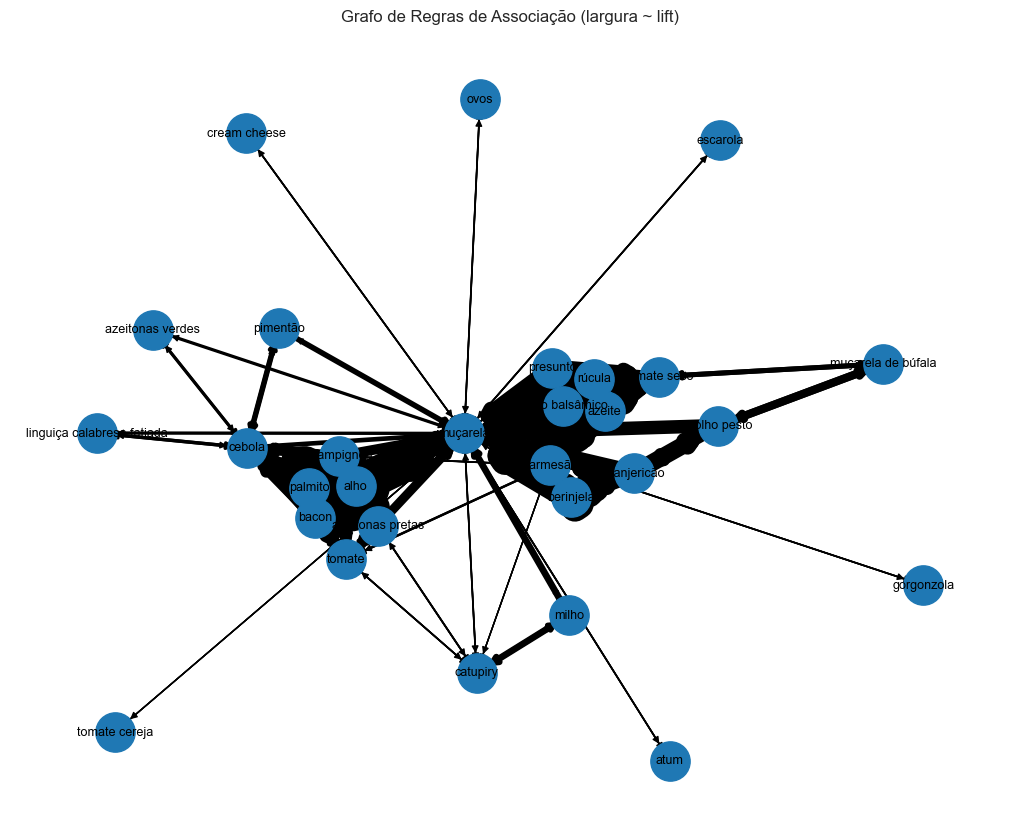

In [12]:

xls_p = pd.ExcelFile(file_pizza)
sheet = 'pizzaingredientes'
if sheet not in xls_p.sheet_names:
    for s in xls_p.sheet_names:
        if s.lower() == 'pizzaingredientes':
            sheet = s; break
df_pz = pd.read_excel(file_pizza, sheet_name=sheet)

ren = {}
for c in df_pz.columns:
    lc = str(c).strip().lower()
    if 'pizza' == lc: ren[c] = 'pizza'
    if 'ingred' in lc: ren[c] = 'ingredientes'
df_pz = df_pz.rename(columns=ren)
assert {'pizza','ingredientes'}.issubset(df_pz.columns)

def split_ings(x):
    if pd.isna(x): return []
    txt = str(x).lower()
    for sep in [';', '/', '\\', '|']:
        txt = txt.replace(sep, ',')
    parts = [p.strip() for p in txt.split(',') if p.strip()]
    return parts

tx = df_pz.assign(items=lambda d: d['ingredientes'].apply(split_ings))[['pizza','items']]
all_items = sorted({i for lst in tx['items'] for i in lst})
basket = pd.DataFrame(0, index=tx['pizza'], columns=all_items, dtype=int)
for pizza, items in tx.itertuples(index=False):
    for it in items: basket.at[pizza, it] = 1

freq = apriori(basket.astype(bool), min_support=0.03, use_colnames=True)
rules = association_rules(freq, metric='support', min_threshold=0.03)

def set_to_text(s):
    return ', '.join(sorted(list(s))) if hasattr(s, '__iter__') else str(s)

rules_fmt = rules.assign(
    antecedents_txt = rules['antecedents'].apply(set_to_text),
    consequents_txt = rules['consequents'].apply(set_to_text)
)[['antecedents_txt','consequents_txt','support','confidence','lift']]

top_support = rules_fmt.sort_values('support', ascending=False).head(10)
top_lift = rules_fmt.sort_values('lift', ascending=False).head(10)

print("=== (2.1.a) Top 10 por SUPORTE ===")
display(top_support)
print("\n=== (2.1.b) Top 10 por LIFT ===")
display(top_lift)

def rules_to_text(df):
    return "\n".join([f"{r['antecedents_txt']} -> {r['consequents_txt']} | support={r['support']:.4f} | confidence={r['confidence']:.4f} | lift={r['lift']:.4f}" for _,r in df.iterrows()])

print("\n--- Regras Top 10 por SUPORTE ---")
print(rules_to_text(top_support))
print("\n--- Regras Top 10 por LIFT ---")
print(rules_to_text(top_lift))

# Grafo
G = nx.DiGraph()
for _, r in rules_fmt.iterrows():
    ants = [a.strip() for a in r['antecedents_txt'].split(',') if a.strip()]
    cons = [c.strip() for c in r['consequents_txt'].split(',') if c.strip()]
    for a in ants:
        for c in cons:
            G.add_edge(a, c, weight=float(r['lift']))

plt.figure(figsize=(10,8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=800, font_size=9)
nx.draw_networkx_edges(G, pos, width=[d['weight'] for *_, d in G.edges(data=True)])
plt.title("Grafo de Regras de Associação (largura ~ lift)")
plt.show()
